In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import transforms,datasets
import timeit
from skimage import io, transform
import os
from torch.utils.data import Dataset
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#importing labels
df = pd.read_excel("labels.xlsx", header=None)
df.head(5)

,0,1,2,3,4
0,EUNRORPXgAEm4oe.jfif,Source-1,0,0,1
1,EUNRPogXYAAzIUt.jfif,Source-1,0,0,1
2,EUNRQsxWAAM_rOW.jfif,Source-1,0,0,1
3,EUNRSF8XYAAY1cg.jfif,Source-1,0,0,1
4,EUR2CTsWoAAo4O9.jfif,Source-1,0,0,1


In [3]:
#different types of labesls it contained
Non_Pneumonia_class = pd.unique(df[2])
Non_Pneumonia_class
Other_Pneumonia_class = pd.unique(df[3])
Other_Pneumonia_class
Covid_19_class = pd.unique(df[3])
Covid_19_class

array([0, 1], dtype=int64)

In [4]:
#Count of labelsfor class imbalance
Non_Pneumonia_count = df[2].value_counts()
Non_Pneumonia_count

0    375
1      8
Name: 2, dtype: int64

In [5]:
#Count of labelsfor class imbalance
Other_Pneumonia_count = df[3].value_counts()
Other_Pneumonia_count

0    329
1     54
Name: 3, dtype: int64

In [6]:
#Count of labelsfor class imbalance
covid_count = df[4].value_counts()
covid_count

1    321
0     62
Name: 4, dtype: int64

In [9]:
#methods to remove class imbalance 
proportion = 83/383
label_count = int(covid_count[1]*proportion)
test_df = df[df[4]==1].sample(label_count)
label_count = int(covid_count[0]*proportion)
test_df = test_df.append(df[df[4]==0].sample(label_count))
label_count = int(Non_Pneumonia_count[1]*proportion)
test_df = test_df.append(df[df[2]==1].sample(label_count))
label_count = int(Non_Pneumonia_count[0]*proportion)
test_df = test_df.append(df[df[2]==0].sample(label_count))
label_count = int(Other_Pneumonia_count[1]*proportion)
test_df = test_df.append(df[df[3]==1].sample(label_count))
label_count = int(Other_Pneumonia_count[0]*proportion)
test_df = test_df.append(df[df[3]==0].sample(label_count))
test_df = test_df.iloc[:83]
test_df = test_df.sample(frac = 1)
train_df = df
for i in test_df.index:
    if(i in train_df.index):
        train_df.drop(i,inplace=True,axis=0)
train_df = train_df.iloc[:300]
train_df = train_df.sample(frac = 1)
train_df.reset_index(drop=True,inplace = True)
test_df.reset_index(drop=True,inplace = True)

In [10]:
class covid_dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.digits_frame = dataframe               #can be used by reading file here instead of directly taking dataframe as input
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.digits_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.digits_frame.iloc[idx, 0])
        image = io.imread(img_name)
        image = Image.open(img_name)
#         if image.getbands()[0] == 'L':
        image = image.convert('L')
#         image = Image.fromarray(np.uint8((image)*255))
    
        pneu = self.digits_frame.iloc[idx, 2]
        pneu = np.array([pneu])
        
        other = self.digits_frame.iloc[idx, 3]
        other = np.array([other])
        
        covid = self.digits_frame.iloc[idx, 4]
        covid = np.array([covid])
        if self.transform:
            image = self.transform(image)

        return image,pneu,other,covid    

batch_size = 32
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_set = covid_dataset(train_df,'images',transform = transform)
test_set = covid_dataset(test_df,'images',transform = transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [11]:
#Traing model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        print(self.conv1)
        self.conv1_drop = nn.Dropout2d(p=0.4)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.4)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc1_drop = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(120, 84)
        self.fc1_drop = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

net = LeNet()

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))


In [12]:
#parameters assignment and data distribution
from torch import optim
from sklearn.model_selection import KFold

learning_rate=0.005
num_epochs=5
criterion = nn.NLLLoss()
op = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.025) 

kf = KFold(5)
fold_count = 0
folds = 5
train_loss = [[]*folds]*num_epochs
train_acc = [[]*folds]*num_epochs
valid_loss = [[]*folds]*num_epochs
valid_acc = [[]*folds]*num_epochs
dataset_sizes = pd.DataFrame({'train':[250],'valid':[50]})

In [18]:

time_taken = timeit.default_timer()
for train_idx, valid_idx in kf.split(train_df):
        
        
        train_fold_df = train_df.iloc[train_idx].copy()
        valid_fold_df = train_df.iloc[valid_idx].copy()
        
        train_fold_df.reset_index(drop=True,inplace=True)
        valid_fold_df.reset_index(drop=True,inplace=True)
        
        train_fold = covid_dataset(train_fold_df,'images',transform = transform)
        valid_fold = covid_dataset(valid_fold_df,'images',transform = transform)

        trainloader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_fold, batch_size=batch_size, shuffle=True)

        best_model_wts = net.state_dict()
        best_acc = 0

        scheduler = optim.lr_scheduler.CosineAnnealingLR(op, num_epochs)

        
        print('FOLD ',fold_count+1,'\n')
        for epoch in range(num_epochs):
                    
                    
                        for phase in ['train','valid']:
                            if phase == 'train':
                                net.train(True)
                                dataloader = trainloader
                            else:
                                net.train(False)
                                dataloader = validloader

                            running_loss = 0.0 
                            running_corr = 0
                            
                            for i,data in enumerate(dataloader):
                                inputs,pneu,other,covid = data
                                pneu=pneu.squeeze()
                                other=other.squeeze()
                                covid=covid.squeeze()

                                #Initializing model gradients to zero
                                if phase == 'train':
                                    net.zero_grad()
                                    op.zero_grad() 
                                outputs = net(inputs)
                                preds = torch.argmax(outputs,dim=1)

                                # Finding the loss
                                loss = criterion(outputs, covid)

                                if phase=='train':
                                    loss.backward()
                                    op.step()
                                        
                                    
                                # Accumulating loss
                                running_loss += loss 
                                # Accumulating correct predictions
                                running_corr += torch.sum(preds==covid)    

                            for f in net.parameters():
                                f.data.sub_(f.grad.data * learning_rate)

                            epoch_loss = running_loss.item()/dataset_sizes[phase]   
                            #Total loss
                            epoch_acc = running_corr.item()/dataset_sizes[phase]

                            if phase =='valid' and epoch_acc.item() > best_acc:
                                best_acc = epoch_acc.item()
                                best_model_wts = net.state_dict()

                            if phase == 'train':
                                train_loss[fold_count].append(epoch_loss) 
                                #Saving loss 
                                train_acc[fold_count].append(epoch_acc) 
                                #Saving accuracy
                                print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f} '.format(epoch+1,num_epochs,epoch_loss.item(),epoch_acc.item()))


                            else:
                                valid_loss[fold_count].append(epoch_loss)
                                valid_acc[fold_count].append(epoch_acc)
                                print('Epoch {:.0f}/{:.0f} : Validation loss: {:.4f} | Validation Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss.item(),epoch_acc.item()))
                        
                        scheduler.step()       
                        
        fold_count = fold_count + 1
        print("\n")
print("\nTotal Training time = ",timeit.default_timer()-time_taken,' seconds')

FOLD  1 

Epoch 1/5 : Training loss: 0.0348 | Training Accuracy: 0.8160 
Epoch 1/5 : Validation loss: 0.0342 | Validation Accuracy: 0.2400
Epoch 2/5 : Training loss: 0.0210 | Training Accuracy: 0.6240 
Epoch 2/5 : Validation loss: 0.0232 | Validation Accuracy: 0.9600
Epoch 3/5 : Training loss: 0.0149 | Training Accuracy: 0.8160 
Epoch 3/5 : Validation loss: 0.0236 | Validation Accuracy: 0.9600
Epoch 4/5 : Training loss: 0.0158 | Training Accuracy: 0.8160 
Epoch 4/5 : Validation loss: 0.0226 | Validation Accuracy: 0.9600
Epoch 5/5 : Training loss: 0.0140 | Training Accuracy: 0.8160 
Epoch 5/5 : Validation loss: 0.0215 | Validation Accuracy: 0.9600


FOLD  2 

Epoch 1/5 : Training loss: 0.0151 | Training Accuracy: 0.8120 
Epoch 1/5 : Validation loss: 0.0200 | Validation Accuracy: 0.9800
Epoch 2/5 : Training loss: 0.0148 | Training Accuracy: 0.8120 
Epoch 2/5 : Validation loss: 0.0210 | Validation Accuracy: 0.9800
Epoch 3/5 : Training loss: 0.0140 | Training Accuracy: 0.8120 
Epoch 3/5 : 

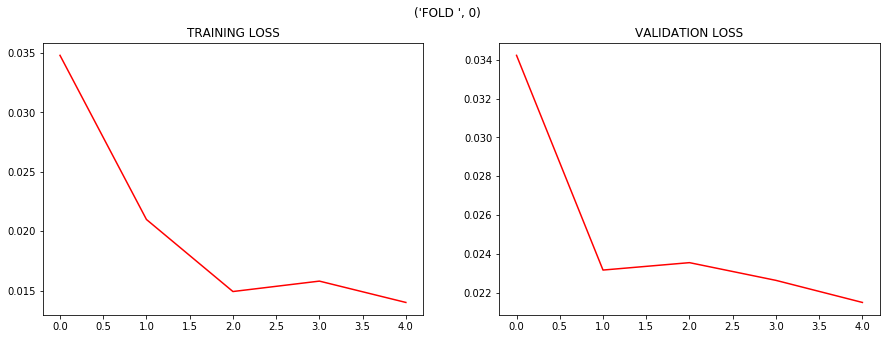

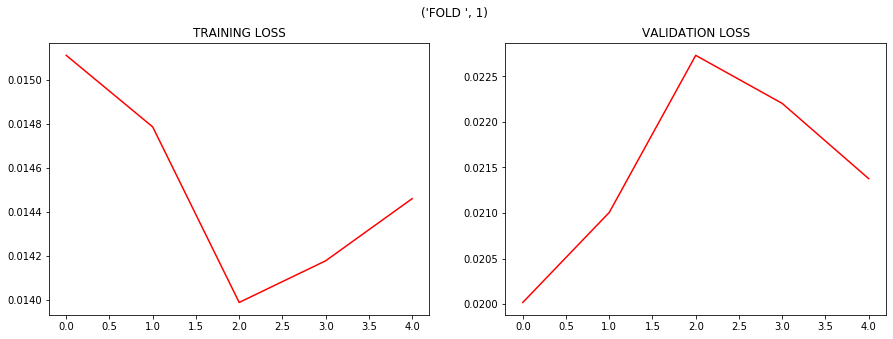

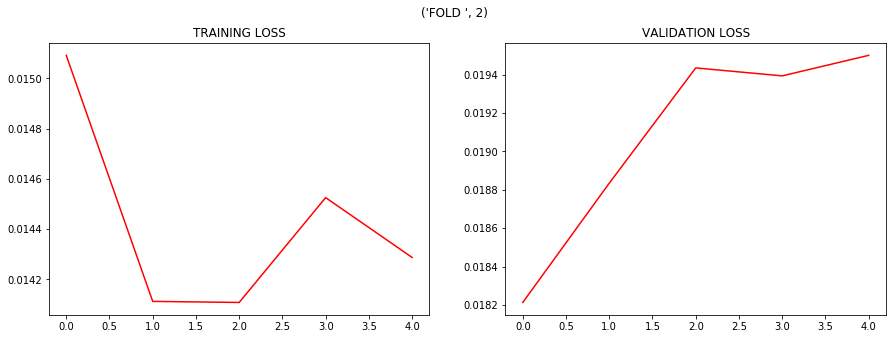

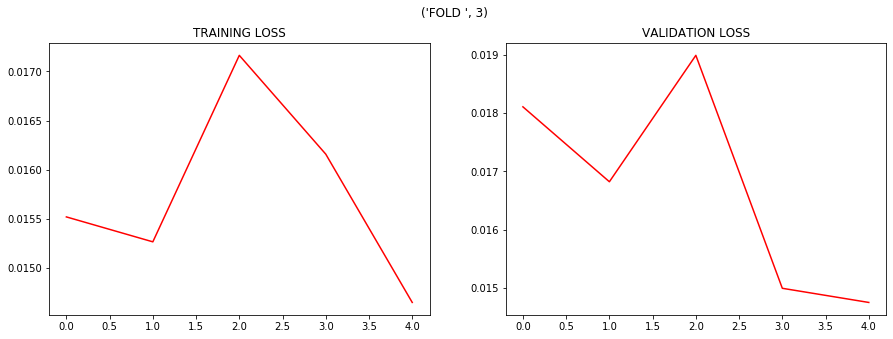

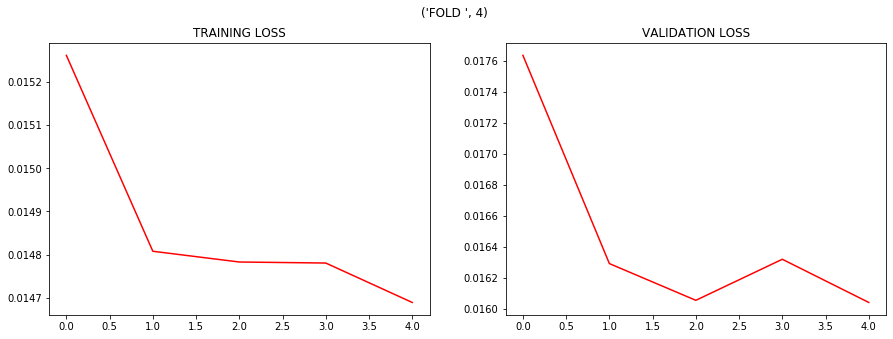

In [19]:
#training and validation loss curves
train_loss = np.array(train_loss)[0]
train_loss = train_loss.reshape((5,num_epochs))
valid_loss = np.array(valid_loss)[0]
valid_loss = valid_loss.reshape((5,num_epochs))
train_acc = np.array(train_acc)[0]
train_acc = train_acc.reshape((5,num_epochs))
valid_acc = np.array(valid_acc)[0]
valid_acc= valid_acc.reshape((5,num_epochs))
for i in range(folds):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(num_epochs),train_loss[i],'r')
    plt.title("TRAINING LOSS")
    plt.subplot(122)
    plt.plot(range(num_epochs),valid_loss[i],'r')
    plt.title("VALIDATION LOSS")
    plt.suptitle(('FOLD ',i))

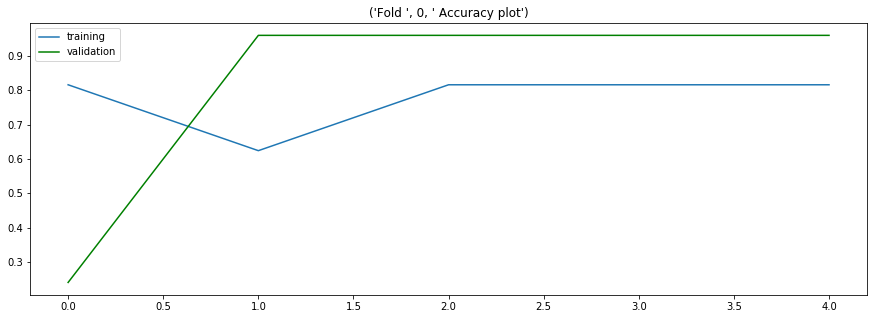

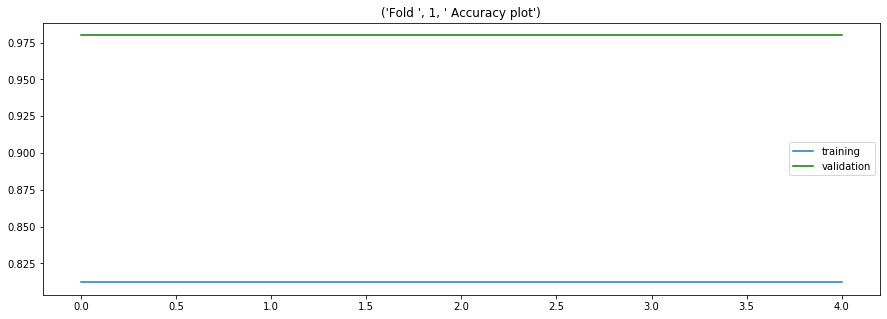

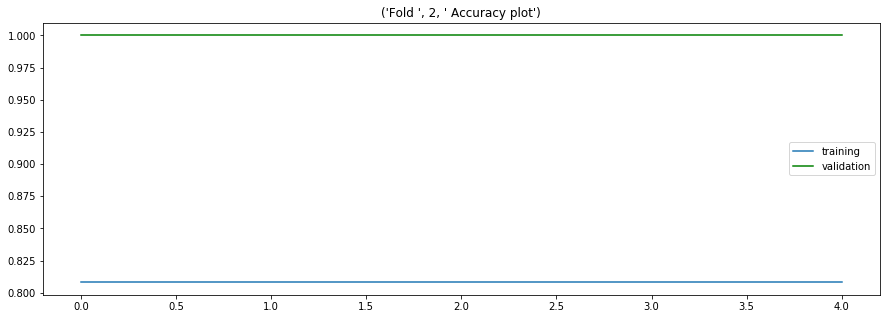

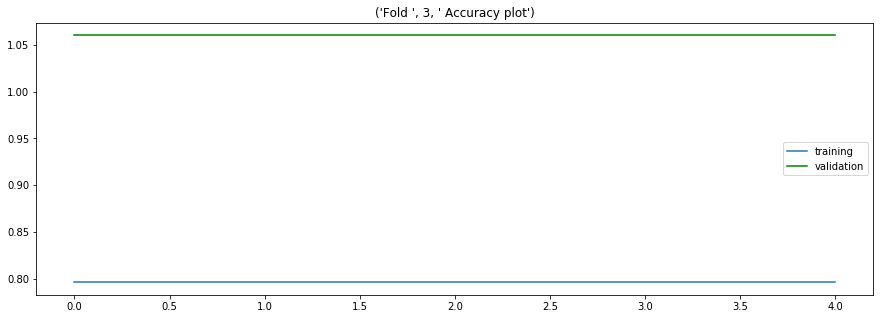

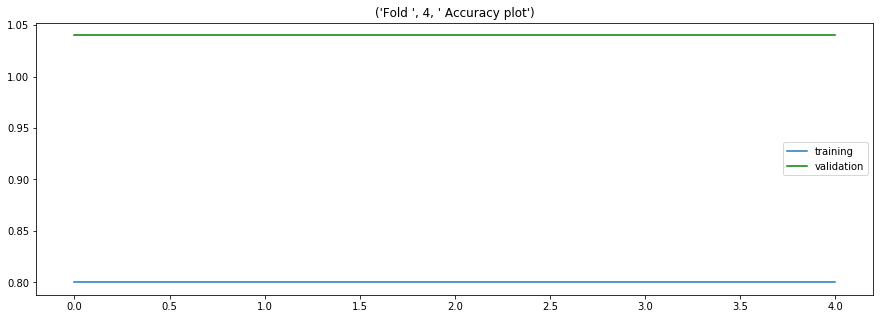

In [20]:
for i in range(folds):
    plt.figure(figsize =(15,5))
    plt.plot(range(num_epochs),train_acc[i])
    plt.plot(range(num_epochs),valid_acc[i],'g')
    plt.title(('Fold ',i," Accuracy plot"))
    plt.legend(('training','validation'))

In [22]:
#Calculating accuracy
test_pred = torch.LongTensor()
for i,data in enumerate(testloader):
    inputs,pneu,other,covid = data
    output = net(inputs) 
    preds = torch.argmax(output,dim=1)
    test_pred = torch.cat((test_pred, preds), dim=0)
    
correct = 0
for i in range(len(test_df[4])):
    if(test_pred[i]==test_df[4][i]):
        correct += 1
print('ACCURACY:',100*(correct/len(test_df[4])))

ACCURACY: 83.13253012048193
